In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [25]:
with open("OULAD/saved_click_data_BBB.pkl", "rb") as fp:   #Pickling
    savedata = pickle.load(fp)
y_train = savedata[3]
y_test = savedata[2]
actionArray_train = savedata[0]
actionArray_test = savedata[1]

In [26]:
# merge distinction and pass 
y_train[y_train==2] = 0 
y_test[y_test==2] = 0

In [27]:
[a, b] = np.unique(y_train, return_counts=True)
print(a)
print(b)

[a, b] = np.unique(y_test, return_counts=True)
print(a)
print(b)

[0 1]
[1899  891]
[0 1]
[1866  713]


In [28]:
# construct the data form for LSTM

total_weeks = 37

usedweeks = 35 # use 35-weeks' data

X = list()

for i in range(total_weeks):
    seq_x = np.sum(actionArray_train[:, (7*i):(7*i+6), :], axis=1)
    X.append(seq_x)
X = np.array(X)

actionWeeks = np.swapaxes(X, 0, 1)

def prepare_data(actionWeeks, weeks=1):
    return actionWeeks[:,:weeks,:]

X_train = prepare_data(actionWeeks, weeks=usedweeks)


In [29]:
X = list()

for i in range(total_weeks):
    seq_x = np.sum(actionArray_test[:, (7*i):(7*i+6), :], axis=1)
    X.append(seq_x)
X = np.array(X)

actionWeeks = np.swapaxes(X, 0, 1)

def prepare_data(actionWeeks, weeks=1):
    return actionWeeks[:,:weeks,:]

X_test = prepare_data(actionWeeks, weeks=usedweeks)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

XX = np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], X_train.shape[2]))
scaler.fit(np.log(XX + 1))
XX = scaler.transform(np.log(XX+1))

X_train = np.reshape(XX, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

XX_test = np.reshape(X_test, (X_test.shape[0]*X_test.shape[1], X_test.shape[2]))
XX_test = scaler.transform(np.log(XX_test+1))
X_test = np.reshape(XX_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [31]:
import numpy as np
import matplotlib as plt
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\gmsliche\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [32]:
from networks import IMVTensorLSTM
# from networks import IMVFULLLSTM

In [33]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [34]:
X_train_t = torch.Tensor(X_train)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_test_t = torch.Tensor(y_test)

In [35]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64, shuffle=False)

In [36]:
# model = IMVFullLSTM(X_train_t.shape[2], 1, 128).cuda() 
# if using cuda, we need to change to cuda in corresponding codes
model = IMVTensorLSTM(X_train_t.shape[2], 1, 128)

In [37]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [38]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_auc_score, accuracy_score

In [39]:
epochs = 50
loss = nn.BCEWithLogitsLoss()


losses = []
losses_test = []

auc_train = []
auc_test = []

acc_train = []
acc_test = []

alphas_train = []
betas_train = []

for i in range(epochs):
    print('the current epoch is {}'.format(i))
    mse_train = 0
    
    alphas = []
    betas = []
    
    for batch_x, batch_y in train_loader:
        batch_x = batch_x
        batch_y = batch_y
        opt.zero_grad()
        y_pred, a, b = model(batch_x)
        
#         print(a.size())
#         print(b.size())
        
        alphas.append(a.detach().numpy())
        betas.append(b.detach().numpy())
        
#         print(y_pred.size())
        
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()
        opt.step()
    
    
    alphas = np.concatenate(alphas)
    betas = np.concatenate(betas)
    
    alphas = alphas.mean(axis=0)
    betas = betas.mean(axis=0)
    
    alphas = alphas[..., 0]
    betas = betas[..., 0]
    
    alphas_train.append(alphas)
    betas_train.append(betas)
        
    epoch_scheduler.step()
    
    epoch_loss_train = mse_train / len(train_loader)
    losses.append(epoch_loss_train)
        
    with torch.no_grad(): # for validation or test
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in test_loader:
            batch_x = batch_x
            batch_y = batch_y
            output, alphas, betas = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()#*batch_x.shape[0]
    
        epoch_loss_test = mse_val / len(test_loader)
        losses_test.append(epoch_loss_test)
        
        
    out,_,_ = model(X_train_t)
    out = out.detach()
    pred_train_prob = torch.sigmoid(out.squeeze(1)) # probability
    
    out,_,_ = model(X_test_t)
    out = out.detach()
    pred_test_prob = torch.sigmoid(out.squeeze(1)) # probability
   
    train_AUC = roc_auc_score(y_train, pred_train_prob)
    
    auc_train.append(train_AUC)
    
    test_AUC = roc_auc_score(y_test, pred_test_prob)
    
    auc_test.append(test_AUC)
    
    pred_train_labels = pred_train_prob
    pred_train_labels = np.where(pred_train_labels > 0.5, 1, 0)
    
    pred_test_labels = pred_test_prob
    pred_test_labels = np.where(pred_test_labels > 0.5, 1, 0)
    
    train_acc = accuracy_score(y_train, pred_train_labels)
    test_acc = accuracy_score(y_test, pred_test_labels)
    
    acc_train.append(train_acc)
    acc_test.append(test_acc)
    
    print('[%d, %5d] training loss: %.3f, training AUC:%.3f, training acc:%.3f,  test loss: %.3f, test AUC:%.3f, test acc:%.3f' %
          (epochs, i + 1, epoch_loss_train, train_AUC, train_acc, epoch_loss_test, test_AUC, test_acc))

the current epoch is 0
[50,     1] training loss: 0.629, training AUC:0.790, training acc:0.681,  test loss: 0.529, test AUC:0.789, test acc:0.724
the current epoch is 1
[50,     2] training loss: 0.543, training AUC:0.782, training acc:0.681,  test loss: 0.542, test AUC:0.776, test acc:0.724
the current epoch is 2
[50,     3] training loss: 0.549, training AUC:0.817, training acc:0.706,  test loss: 0.549, test AUC:0.820, test acc:0.665
the current epoch is 3
[50,     4] training loss: 0.527, training AUC:0.789, training acc:0.774,  test loss: 0.478, test AUC:0.792, test acc:0.791
the current epoch is 4
[50,     5] training loss: 0.522, training AUC:0.806, training acc:0.744,  test loss: 0.509, test AUC:0.813, test acc:0.738
the current epoch is 5
[50,     6] training loss: 0.524, training AUC:0.800, training acc:0.777,  test loss: 0.478, test AUC:0.805, test acc:0.790
the current epoch is 6
[50,     7] training loss: 0.529, training AUC:0.805, training acc:0.753,  test loss: 0.509, te

In [40]:
torch.save(model.state_dict(), "imv_tensor_lstm_oulad_bbb.pt")
# model.load_state_dict(torch.load("imv_tensor_lstm_oulad_fff.pt"))

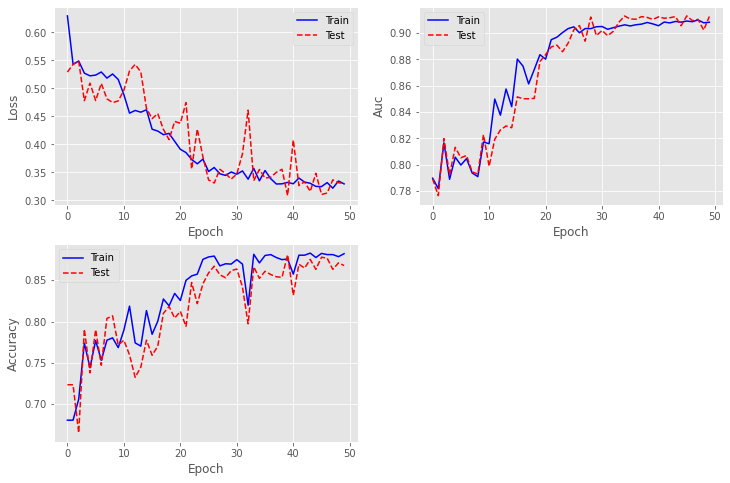

In [41]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

metrics = ['loss', 'AUC', 'accuracy']

plt.figure(figsize=(12, 8))
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()

    plt.subplot(2,2,n+1)
    
    if metric == 'loss':
        plt.plot(range(epochs),  losses, color='b', label='Train')
        plt.plot(range(epochs), losses_test,
             color='r', linestyle="--", label='Test')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.legend()
    if metric == 'AUC':
        plt.plot(range(epochs),  auc_train, color='b', label='Train')
        plt.plot(range(epochs), auc_test,
             color='r', linestyle="--", label='Test')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.legend()
    if metric == 'accuracy':
        plt.plot(range(epochs),  acc_train, color='b', label='Train')
        plt.plot(range(epochs), acc_test,
             color='r', linestyle="--", label='Test')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.legend()

        plt.show()

In [42]:
with torch.no_grad(): # for validation or test
    mse_val = 0
    preds_labels = []
    true_labels = []
    alphas = []
    betas = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x
        batch_y = batch_y
        output, a, b = model(batch_x)
        output = output.squeeze(1)
        preds_labels.append(torch.sigmoid(output.detach()))
        alphas.append(a.detach().numpy())
        betas.append(b.detach().numpy())
        true_labels.append(batch_y.detach().numpy())
        mse_val += loss(output, batch_y).item()#*batch_x.shape[0]

    epoch_loss_test = mse_val / len(test_loader)
    losses_test.append(epoch_loss_test)

preds_labels = np.concatenate(preds_labels)
true_labels = np.concatenate(true_labels)

alphas = np.concatenate(alphas)
betas = np.concatenate(betas)

alphas = alphas.mean(axis=0)
betas = betas.mean(axis=0)

alphas = alphas[..., 0]
betas = betas[..., 0]

alphas = alphas.transpose(1, 0)
alphas_test = alphas
betas_test = betas

In [43]:
alphas_saved = alphas_train
betas_saved = betas_train

In [78]:
# saved_oulad_fff = [alphas_train, betas_train, alphas_test, betas_test, losses, losses_test, auc_train, auc_test]
# import pickle
# with open('results_oulad_bbb.pk', 'wb') as pk:
#     pickle.dump(saved_oulad_fff, pk)

In [79]:
### we show the importance at the end of training

alphas = alphas_train[-1]
betas = betas_train[-1]

# alphas = alphas_test
# betas = betas_test

In [81]:
cols = ['resource', 'oucontent', 'url', 'homepage', 'subpage', 'glossary', 
        'forumng', 'oucollaborate', 'dataplus', 'quiz', 'ouelluminate', 
        'sharedsubpage', 'questionnaire', 'page', 'externalquiz', 'ouwiki', 
        'dualpane', 'repeatactivity', 'folder', 'htmlactivity']

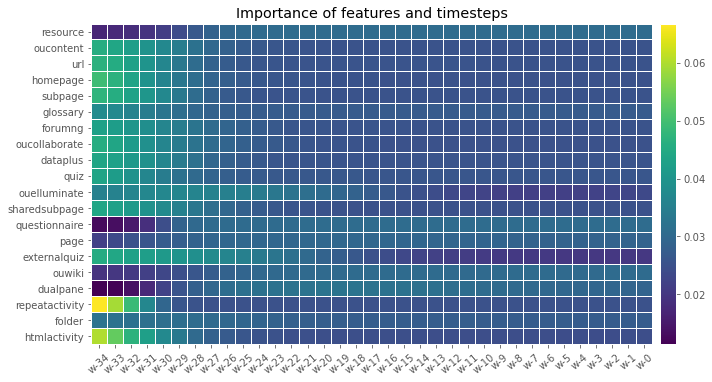

In [82]:
alphas = alphas.transpose(1,0)
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
fig, ax = plt.subplots(figsize=(10, 10))
# im = ax.imshow(alphas)
cf = plt.pcolormesh(alphas, edgecolors='w', linewidth=0.01)
ax = plt.gca()
ax.set_aspect('equal')
add_colorbar(cf)

ax.set_xticks(np.arange(0.5, X_train_t.shape[1], 1))
ax.set_yticks(np.arange(0.5, len(cols), 1))
ax.set_xticklabels(["w-"+str(i) for i in np.arange(X_train_t.shape[1]-1, -1, -1)], rotation=40)
ax.set_yticklabels(cols[::-1])
ax.set_title("Importance of features and timesteps")
fig.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x26c05ed77c0>,
 [Text(0, 0, 'resource'),
  Text(1, 0, 'oucontent'),
  Text(2, 0, 'url'),
  Text(3, 0, 'homepage'),
  Text(4, 0, 'subpage'),
  Text(5, 0, 'glossary'),
  Text(6, 0, 'forumng'),
  Text(7, 0, 'oucollaborate'),
  Text(8, 0, 'dataplus'),
  Text(9, 0, 'quiz'),
  Text(10, 0, 'ouelluminate'),
  Text(11, 0, 'sharedsubpage'),
  Text(12, 0, 'questionnaire'),
  Text(13, 0, 'page'),
  Text(14, 0, 'externalquiz'),
  Text(15, 0, 'ouwiki'),
  Text(16, 0, 'dualpane'),
  Text(17, 0, 'repeatactivity'),
  Text(18, 0, 'folder'),
  Text(19, 0, 'htmlactivity')])

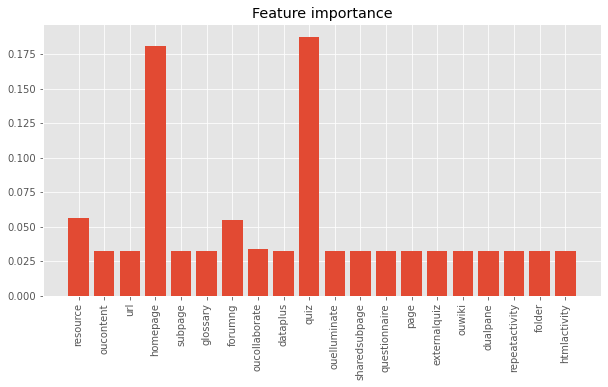

In [83]:
plt.figure(figsize=(10, 5))
plt.title("Feature importance")
# plt.bar(range(len(cols)), betas)
plt.bar(range(len(cols)), betas)
plt.xticks(ticks=range(len(cols)), labels=cols, rotation=90)

In [84]:
import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

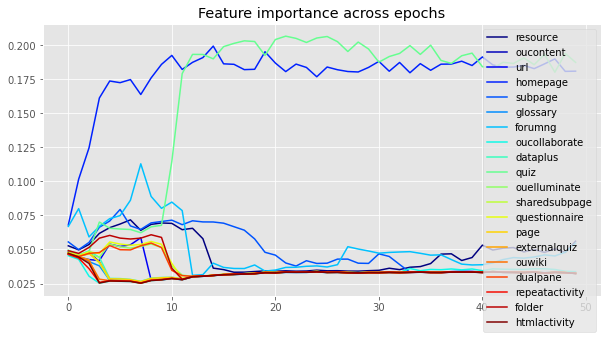

In [77]:
plt.figure(figsize=(10, 5))
plt.title("Feature importance across epochs")
colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 20)))) 

vi = np.concatenate(betas_train).reshape(epochs,-1).T

for i in range(vi.shape[0]):
    plt.plot(np.arange(vi.shape[1]), vi[i,:])
    

# plt.legend(["fea-"+str(i) for i in np.arange(-1, vi.shape[0]-1, 1)])
plt.legend(cols)
plt.show()